In [1]:
import itertools

import numpy as np
import pandas as pd

import altair as alt
import bokeh.io
from bokeh.layouts import row

import bebi103
import altair_catplot as altcat

bokeh.io.output_notebook()

Loading BokehJS ...

**a)**
First of all, we can load the data by using the function in Panda package, and take a look if the data is tidy.

In [2]:
df = pd.read_excel('wang_cool_gal4.xlsx')
df.head()

,sc15,sc20,sc25,sk15,sk20,sk25,m315,m320,m325
0,1298.547,2737.135,16499.30,8978.031,14251.97,16593.960,20722.62,11703.01,17073.800
1,6798.146,12185.360,12672.19,11221.130,13616.94,6910.673,10373.52,17025.58,15379.370
2,10686.910,1532.901,15832.53,9460.200,17474.90,20934.660,21707.12,17499.83,16991.490
3,2018.864,2357.752,15065.03,9049.072,16042.57,18042.750,21750.27,15657.50,13393.350
4,1551.396,1888.596,16960.67,14132.810,12867.40,23189.560,20820.26,11383.33,7709.297


**b)**
It is not tidy since the reading of each condition (genotype and temperature) forms a column, and we may want to have three columns that denote 'genotype', 'temperature', and the reading for each measurement. This operation is pretty similar to what we did in the tutorial, so first we use the stack function to move the horizontal index to vertical index, sort the data by conditions, reset the index and take a look.

In [41]:
df_tidy = df.stack(level = 0)
df_tidy = df_tidy.sort_index(level = 1)
df_tidy = df_tidy.reset_index(level = 1)
df_tidy.head()

,level_1,0
0,sc15,1298.547
1,sc15,6798.146
2,sc15,10686.910
3,sc15,2018.864
4,sc15,1551.396


Before we proceed, we check if there is any NaN inside the reading and We don't need to worry about the first column because values all come from the condition.

In [44]:
np.isnan(df_tidy.loc[:,0]).unique()

array([False])

It looks like the stack operation has already removed all the Nans. Now we have the condition and reading as parameters sitting in the columns with the default names though, so the first step we take is to rename the column as 'Condition', and the reading as 'Fluorescence'.

In [45]:
df_tidy = df_tidy.rename(columns={'level_1': 'Condition'})
df_tidy = df_tidy.rename(columns={0: 'Fluorescence'})
df_tidy.head()

,Condition,Fluorescence
0,sc15,1298.547
1,sc15,6798.146
2,sc15,10686.910
3,sc15,2018.864
4,sc15,1551.396


Then we take a look at how many conditions we have and how we can separate them into temperature and genotype. 

In [46]:
df_tidy['Condition'].unique()

array(['sc15', 'sc20', 'sc25', 'sk15', 'sk20', 'sk25', 'm315', 'm320',
       'm325'], dtype=object)

In this case, the first two characters of each string in this column denote the genotype, while the past two denote the temperature, so we just take the first part of the condition as one column 'Genotype' and the rest as one column 'Temperature'. Although we want genotype and temperature separate, we think it is still valuable to keep this condition for possible needs, so we will not drop the column after separation for now. Besides the extra 'Condition' column, the DataFrame is now tidy.

In [47]:
df_tidy['Genotype'] = df_tidy.Condition.str[0:2]
df_tidy['Temperature'] = df_tidy.Condition.str[2:]
df_tidy.head()

,Condition,Fluorescence,Genotype,Temperature
0,sc15,1298.547,sc,15
1,sc15,6798.146,sc,15
2,sc15,10686.910,sc,15
3,sc15,2018.864,sc,15
4,sc15,1551.396,sc,15


**c)**
We have two parameters in this experiment, but we only have one variables measured, in which case we need to separate those two parameters and compare them one by one. Thus, we want two sets of plots where we compare the fluorescence of each genotype in different temperature in one, and compare that of different genotypes in each specific temperature in the other. In term of the way to plot, we choose the ECDF because the part that we care the most about is the distribution of fluorescence readings for different conditions so that we can have an idea about how they perform. Before plotting, we look at the range of the readings, so that we can use the same and appropriate axis range for all the plots.

In [50]:
df_tidy['Fluorescence'].max()

43198.42

In [51]:
df_tidy['Fluorescence'].min()

492.0972

As shown above, we choose to set the range from 0 to 450000, and we assign a scale variable so that it can be used in all the plots easily. Also, we want to use loop construct to plot so we have a empty variable assigned for further appending.

In [109]:
axis_scale = alt.Scale(domain=[0, 45000])
p = []

Now we can fix the temperature, plot the ECDF for different genotypes in this temperature and then loop over all the temperatures. We put thsoe three plots together so that we can compare the fluorescence of three genotypes in each temperature.

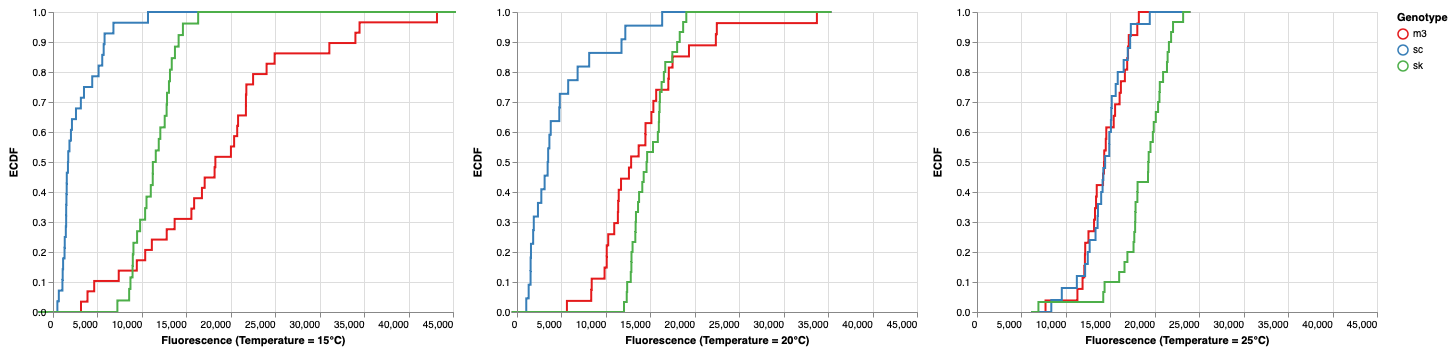

In [110]:
for t in df_tidy['Temperature'].unique().astype('str'):
    p_temp = altcat.catplot(data=df_tidy.loc[df_tidy['Temperature'] == t,:],
                        mark='line',
                        encoding=dict(x=alt.X('Fluorescence:Q',scale=axis_scale,title='Fluorescence (Temperature = ' + str(t)+u'\u2103)'),
                                     color=alt.Color('Genotype:N', title='Genotype', scale=alt.Scale(scheme='set1'))),
                        transform='ecdf')
    p.append(p_temp)


p[0] | p[1] | p[2]

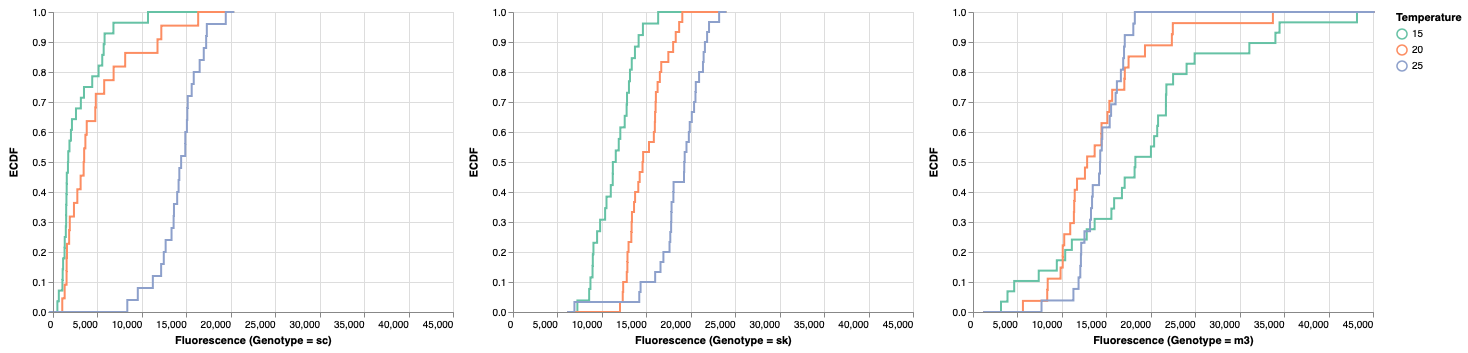

In [111]:
for g in df_tidy['Genotype'].unique().astype('str'):
    p_temp = altcat.catplot(data=df_tidy.loc[df_tidy['Genotype'] == g,:],
                        mark='line',
                        encoding=dict(x=alt.X('Fluorescence:Q',scale=axis_scale,title='Fluorescence (Genotype = ' + g + ')'),
                                     color=alt.Color('Temperature:N', title='Temperature', scale=alt.Scale(scheme='set2'))),
                        transform='ecdf')
    p.append(p_temp)

p[3] | p[4] | p[5]

In [46]:
axis_scale = alt.Scale(domain=[0, 45000])

alt.Chart(data=df_tidy.loc[df_tidy['T'] == '15',:],
        height=150,
        width=150
    ).mark_circle(
        size=5,
        opacity=0.1
    ).encode(
        x=alt.X('F:Q', scale=axis_scale),
        y=alt.Y('F:Q', scale=axis_scale),
        color=alt.Color('G:N', title='beetle genus'),
        column=alt.Column('beetle_treatment:N', title='beetle genus'),
    )

Column({
  shorthand: 'T:Q',
  title: 'T'
})

In [15]:
def 
# Box plot
p = bebi103.viz.box(data=df_tidy.loc[df_tidy['T'] == '25',:], 
                    cats='G',
                    val='F',
                    y_axis_label=None,
                    box_kwargs={'fill_alpha': 0.2},
                    horizontal=True)

# Add jitter; note kwarg p=p to add to existing figure
p = bebi103.viz.jitter(data=df_tidy.loc[df_tidy['T'] == '25',:], 
                       cats='G',
                       val='F',
                       horizontal=True,
                       p=p)
bokeh.io.show(p)

In [ ]:
p3 = altcat.catplot(data=df_tidy,
               mark = 'point',
               encoding=dict(x=alt.X('G:N', title=None),
                             y='F:Q',
                             color=alt.Color('G:N', title='G'),
                             column=alt.Column('T:Q', title='T')),
               transform='jitterbox',
               height = 200,
               width = 300
              )
p3